In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


Consider a simple asset pricing model in which the equilibrium price of a stochastic asset evolves accrodingly to the following law of Motion
\begin{equation}
    p_t = p^{e}_{t+1} + u_t,
\end{equation}

where $p_t$ is the equilibrium price at time $t$, $p^{e}_{t+1}$ is the expected price at time $t+1$ formed at time $t$ \textit{before} the realization of the equilibrium price and $u_t \sim N(0, \sigma^2_u)$.
We assume that agents are boundedly rational and are not aware of the true data generating process.
Instead they rely on econometric techniques to form their expectations.
Specifically we assume that agents have a linear and stationary perceived law of motion (PLM) for the asset return 
\begin{equation}
r_{t+1} = \beta \theta_t + \varepsilon_t,
\end{equation}
where $\theta_t$ is a stochastic signal that agents observe and $\varepsilon_t \sim N(0, \sigma^2_\varepsilon)$.

In order to estimate the parameter agent use Recursive Ordinary Least square of the form 

\begin{equation}
\hat{\beta_t} = \frac{\sum^{t-1}_{s=0} r_{s} \theta_{s-1}}{\sum^{t-1}_{s=0}(\theta_{s-1})^2},
\end{equation}

in which the time indexes are consistent with the timeline of events which implies that at time $t$ the last observable return that can be used for estimation is $r_{t-1}$.
The Actual Law of Motion (ALM) for the asset price obtains by substituting the PLM into the equilibrium condition

\begin{equation}
p_t = p^{e}_{t+1} + u_t = (1 + \hat{\beta_t} \theta_t) p^e_{t},
\end{equation}

where again $p^e_{t}$ stresses that the current price is not available to agents when making their forecats.
Consisten with their model

\begin{equation}
p^e_t = (1 +\hat{\beta_t} \theta_{t+1}) p_{t-1},
\end{equation}
where the use of $\hat{\beta_t}$ is justified by the belief that there is a constant homogenous $\beta$ and so it make sense for agents to use the 'smoothed' estimate obtained by considering also the return at time $t-1$ in place of $\hat{\beta_{t-1}}$.
This implies an ALM for the current price

\begin{equation}
p_t = (1 + \hat{\beta_t} \theta_t)(1 + \hat{\beta_t} \theta_{t-1}) p_{t-1} + u_t,
\end{equation}

and it follows that future returns evolve according to 

\begin{equation}
r_{t+1} = \hat{\beta_{t+1}} \theta_{t+1} + \hat{\beta_{t+1}} \theta_t + (\hat{\beta_{t+1}})^2 \theta_{t+1} \theta_t + \frac{u_t}{p_{t-1}}.
\end{equation}

\subsection{Existence of self-fulfilling equilibria}

A self-fulfilling equilibrium requires consistency between the regression coefficient that agents would estimate from the ALM and the actual $\beta$ implied by their forecast. 
Formally, let the regression coefficient that would be estimated from the ALM if agents used a constant $\beta$ be denoted by $\hat{\beta}$, we require

\begin{equation}
\hat{\beta_t} =  \beta(\hat{\beta_t}) = \frac{\operatorname{Cov}(r_{t+1},\theta_t)}{\operatorname{Var}(\theta_t)}
\end{equation}

where the notation stresses that the population parameter $\beta$ is a function of the estimated parameter $\hat{\beta_t}$.
A self-fulfilling equilibrium is a fixed point of this function, i.e. a solution to the equation $\hat{\beta} = \beta(\hat{\beta})$.

Now
\begin{equation}
\operatorname{Cov}\big(r_{t+1},\theta_t\big)
= \hat{\beta}\,\operatorname{Cov}(\theta_{t+1},\theta_t)
+ \hat{\beta}\,\operatorname{Var}(\theta_t)
+ \hat{\beta}^2\,\operatorname{Cov}(\theta_{t+1}\theta_t,\theta_t)
+ \operatorname{Cov}\!\Big(\frac{u_t}{p_{t-1}},\theta_t\Big).
\end{equation}

Given $u_t$ is mean zero and independent of $\theta$, the last term is zero, moreover if we assume that $\theta_t$ is iid
then every term except the variance is zero and we obtain
\begin{equation}
\hat{\beta}=\hat{\beta},
\end{equation}

which implies that every $\hat{\beta}$ leads to a self-fulfilling equilibrium.


In [2]:
class Least_Square_Learning:
    def __init__(self, p0, pminus1, T=1000):
        self.p_tminus1 = p0
        self.p_tminus2 = pminus1
        self.r_tminus1 = (p0 - pminus1) / pminus1
        self.theta_tminus2 = np.random.normal(0, 1)
        self.theta_tminus1 = np.random.normal(0, 1)
        self.theta_t = np.random.normal(0, 1)
        #compute beta_t by least squares
        self.numerator_t = self.r_tminus1 * self.theta_tminus2
        self.denominator_t = self.theta_tminus2 ** 2
        self.beta_t = self.numerator_t / self.denominator_t 
        self.history_beta = [self.beta_t] #beta_t
        self.history_price = [p0] #p_t-2
        self.history_return = [self.r_tminus1] # r_t-1
        self.history_theta = [self.theta_t] #theta_t
        self.T = T

    def update(self):
        #first we compute p_t
        self.p_t = (1 + self.beta_t * self.theta_t) * (1 + self.beta_t * self.theta_tminus1) * self.p_tminus1 + np.random.normal(0, 1)
        #then we update the return r_t
        self.r_t = (self.p_t - self.p_tminus1) / self.p_tminus1
        #update theta
        self.theta_tplus1 = np.random.normal(0, 1)
        #update beta
        self.numerator_tplus1 = self.numerator_t + self.r_t * self.theta_tminus1
        self.denominator_tplus1 = self.denominator_t + self.theta_tminus1 ** 2
        self.beta_tplus1 = self.numerator_tplus1 / self.denominator_tplus1
        #update variables for next iteration
        self.p_tminus2 = self.p_tminus1
        self.p_tminus1 = self.p_t
        self.r_tminus1 = self.r_t
        self.theta_tminus2 = self.theta_tminus1
        self.theta_tminus1 = self.theta_t
        self.theta_t = self.theta_tplus1
        self.numerator_t = self.numerator_tplus1
        self.denominator_t = self.denominator_tplus1
        self.beta_t = self.beta_tplus1

        #store history
        self.history_beta.append(self.beta_t)
        self.history_price.append(self.p_t)
        self.history_return.append(self.r_t)
        self.history_theta.append(self.theta_t)

    def simulate(self):
        for t in range(self.T):
            self.update()
        return np.array(self.history_price), np.array(self.history_return), np.array(self.history_beta), np.array(self.history_theta)

In [3]:
#simulate for T periods
T = 10000
agent = Least_Square_Learning(p0=100, pminus1=100 + np.random.normal(0, 1), T=T)
p, r, b, theta = agent.simulate()

In [4]:
len(p), len(r), len(b), len(theta)

(10001, 10001, 10001, 10001)

In [5]:
#cpmpute correlation between r and theta shifted by two periods to have r_t and theta_t-1
corr = np.corrcoef(r[2:], theta[:-2])[0, 1]
#compute a "constant beta" as correlation times ratio of std deviations
constant_beta = corr * (np.std(r[2:]) / np.std(theta[:-2]))


Text(0.5, 0, 'Time')

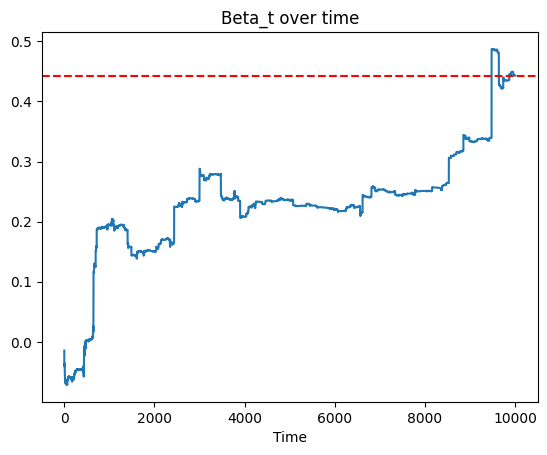

In [6]:
#plot the beta_t over time
plt.plot(b)
plt.title("Beta_t over time")
#add the correlation between r_t and theta_t-1 as horizontal line
plt.axhline(y=constant_beta, color='r', linestyle='--', label=f'Constant Beta: {constant_beta:.2f}')
plt.xlabel("Time")

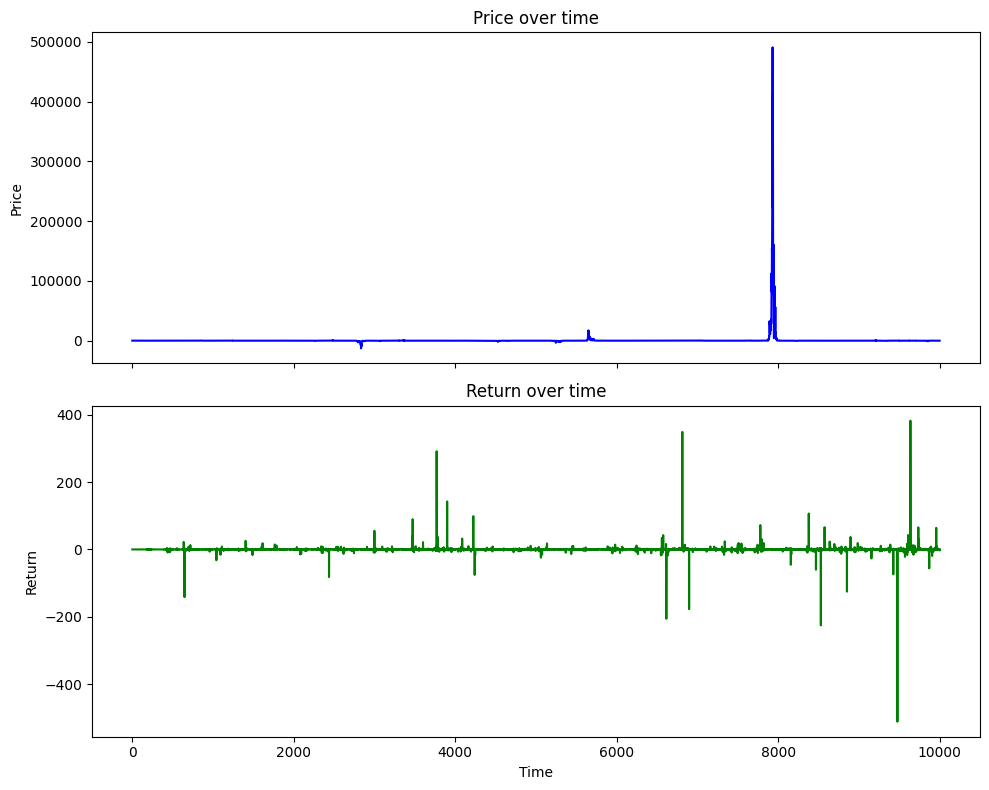

In [7]:
#plot returns and prices
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
axs[0].plot(p, color='blue')
axs[0].set_title("Price over time")
axs[0].set_ylabel("Price")
axs[1].plot(r, color='green')
axs[1].set_title("Return over time")
axs[1].set_ylabel("Return")
axs[1].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [8]:
#Compute sum of total squared returns
avg_return = np.mean(r)
total_squared_return = np.sum((r - avg_return) ** 2)
print(f"Total Squared Return: {total_squared_return}")
print(f"Average Return: {avg_return}")

Total Squared Return: 913818.4342091086
Average Return: 0.03776043859771321


In [9]:
#check if we can predict returns from theta
X = theta[:-2].reshape(-1, 1)  # theta_t-1
y = r[2:]  # r_t

model = sm.OLS(y, sm.add_constant(X)).fit()

#results summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     20.97
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           4.72e-06
Time:                        18:57:29   Log-Likelihood:                -36751.
No. Observations:                9999   AIC:                         7.351e+04
Df Residuals:                    9997   BIC:                         7.352e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0313      0.096      0.328      0.7

In [377]:
class Multiple_Least_Square_Learning:
    def __init__(self, p0, pminus1, K = 10, T=1000, seed = None):
        if seed is not None:
            np.random.seed(seed)
        self.p_tminus1 = p0
        self.p_tminus2 = pminus1
        self.r_tminus1 = np.atleast_2d(np.array((p0 - pminus1) / pminus1))
        #now theta is multivariate normal with K regressors and it's just faster to generate the whole TxK matrix
        self.K = K
        self.theta_matrix = np.random.normal(0, 1, (T+3, K)) #we generate T+2 rows to have enough for t-2, t-1
        self.T = T
        self.t = 0
        self.beta_t = np.zeros(K)
        #history
        self.history_beta = [self.beta_t] #beta_t
        self.history_price = [np.array([p0])] #p_t-2

    def update(self):
        #current theta matrix, from row 0 until row t
        self.theta_tminus2 = np.atleast_2d(self.theta_matrix[0:self.t+1]) #this is the whole history of theta up to t-2
        self.theta_tminus1 = np.atleast_2d(self.theta_matrix[self.t+2]) #this is only the theta at t-1
        self.theta_t = np.atleast_2d(self.theta_matrix[self.t+3]) #this is only the theta at t
        #compute beta_t by least squares

        self.beta_t = (np.linalg.pinv(self.theta_tminus2.T @ self.theta_tminus2) @ self.theta_tminus2.T @ self.r_tminus1).flatten()

        #first we compute p_t
    
        self.p_t = (1 + self.theta_t @ self.beta_t) * (1 + self.theta_tminus1 @ self.beta_t) * self.p_tminus1 + np.random.normal(0, 1)
    
        #print(self.p_t.shape)
        #then we update the return r_t by stacking the new row
        self.r_t = np.vstack([self.r_tminus1, np.atleast_2d((self.p_t - self.p_tminus1) / self.p_tminus1)])

        #update variables for next iteration
        self.p_tminus2 = self.p_tminus1
        self.p_tminus1 = self.p_t
        self.r_tminus1 = self.r_t
    
        #store history
        self.history_beta.append(self.beta_t)
        self.history_price.append(self.p_t)

        #increment time
        self.t += 1
      

    def simulate(self):
        for t in range(self.T):
            self.update()


In [385]:
#simulate for T periods
T = 3_00
K = 5
agent = Multiple_Least_Square_Learning(p0=100, pminus1=100 + np.random.normal(0, 1), K=K, T=T, seed = 1)
agent.simulate()

In [386]:
agent.r_t.flatten()

array([ 7.62178552e-03,  7.82794819e-03, -1.40811756e-02, -5.18288077e-03,
       -2.47326529e-03, -2.17884953e-02,  2.79944384e-01, -2.96301686e-01,
        2.01063058e-01, -9.92550649e-02, -2.54533735e-01, -9.05864581e-02,
       -1.02232616e-02,  4.07774172e-02, -2.85392478e-02, -1.21459522e-01,
       -1.05353341e-01, -1.11758318e-01, -3.35893063e-02,  4.09905187e-02,
        1.88964864e-02, -2.70082683e-02,  4.79040401e-02,  5.62885756e-03,
       -9.48045850e-02, -7.46494530e-03, -5.31540998e-02, -1.68505669e-01,
       -1.82571483e-01, -1.17118414e-01,  5.26967800e-02, -2.82449636e-02,
       -1.86885304e-02, -2.08054196e-02, -6.57031728e-02, -1.07753412e-01,
       -2.27265396e-01, -2.84165647e-01, -2.21496016e-01,  7.46818728e-02,
        1.33476716e-01, -6.44801359e-03, -9.97792715e-02,  1.28553966e-01,
        1.22940534e-01,  2.26876496e-03,  8.04214581e-02,  2.04229504e-01,
        5.50738821e-02, -2.34007251e-02,  4.44992206e-02,  1.19011464e-02,
       -1.00151940e-01, -

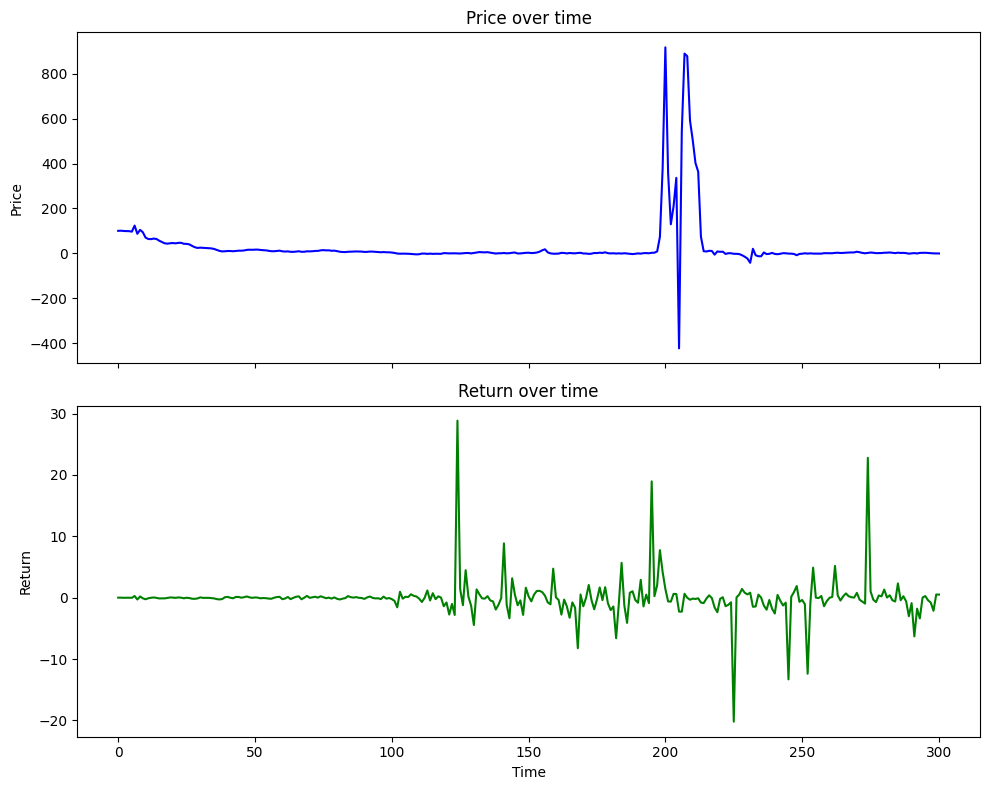

In [387]:
prices = np.vstack(agent.history_price)
rerutns = agent.r_t.flatten()

#PLot of returns and prices
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
axs[0].plot(prices, color='blue')
axs[0].set_title("Price over time")
axs[0].set_ylabel("Price")
axs[1].plot(rerutns, color='green')
axs[1].set_title("Return over time")
axs[1].set_ylabel("Return")
axs[1].set_xlabel("Time")
plt.tight_layout()
plt.show()


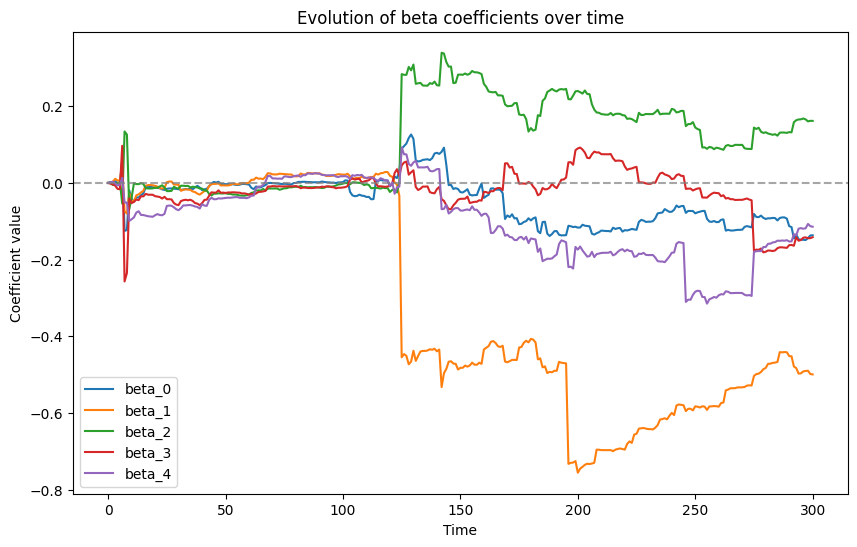

In [388]:
# turn history_beta into a 2D array: shape (T+1, K)
betas = np.vstack(agent.history_beta)

# plot each coefficient over time
plt.figure(figsize=(10,6))
for k in range(betas.shape[1]):
    plt.plot(betas[:, k], label=f"beta_{k}")

#add horizontal line at 0
plt.axhline(y=0, color='gray', linestyle='--', alpha = 0.7)
plt.xlabel("Time")
plt.ylabel("Coefficient value")
plt.title("Evolution of beta coefficients over time")
plt.legend()
plt.show()

In [303]:
def compute_b_star(beta, theta_matrix, u_noise=0.0, p0=1.0, pminus1=1.0):
    """
    Empirically compute b*(beta) = Sigma^{-1} E[r_{t+1}(beta) * theta_t]
    using simulated draws of theta (and optional u noise).
    """
    T, K = theta_matrix.shape
    # simulate prices
    p_hist = np.zeros(T)
    p_hist[0] = pminus1
    p_hist[1] = p0

    # fill forward
    for t in range(1, T-2):  
        theta_tminus1 = theta_matrix[t]
        theta_t = theta_matrix[t+1]
        factor = (1 + theta_t @ beta) * (1 + theta_tminus1 @ beta)
        u = np.random.normal(scale=u_noise)
        p_hist[t+1] = factor * p_hist[t] + u

    # compute returns and regressors
    r_vec = (p_hist[2:T] - p_hist[1:T-1]) / p_hist[1:T-1]      # length T-2
    theta_t_arr = theta_matrix[1:T-1]                          # align with r_vec

    # compute Sigma and cross-moment
    Sigma = np.cov(theta_t_arr, rowvar=False, bias=True)
    m = (theta_t_arr * r_vec[:, None]).mean(axis=0)

    b_star = np.linalg.pinv(Sigma) @ m
    return b_star, Sigma, m, p_hist


# Quick test: generate iid Gaussian theta, check b*(beta) when u_noise large vs zero
K = 5
Tsim = 5000
theta_mat = np.random.normal(size=(Tsim+5, K))

for u_noise in [0.0, 0.5, 1.0]:
    # try several beta candidates (random direction, nonzero magnitude)
    for beta in [np.zeros(K), 0.5*np.ones(K), np.linspace(0,1,K)]:
        bstar, Sigma, m, p_hist = compute_b_star(np.array(beta), theta_mat, u_noise=u_noise, p0=1.0, pminus1=1.0)
        print("u=", u_noise, "beta=", beta[:3], "-> b_star[:3]=", np.round(bstar[:3],4))
    print("-----")


u= 0.0 beta= [0. 0. 0.] -> b_star[:3]= [-0.0003  0.0005 -0.0001]
u= 0.0 beta= [0.5 0.5 0.5] -> b_star[:3]= [nan nan nan]
u= 0.0 beta= [0.   0.25 0.5 ] -> b_star[:3]= [nan nan nan]
-----
u= 0.5 beta= [0. 0. 0.] -> b_star[:3]= [0.0189 0.0086 0.0083]
u= 0.5 beta= [0.5 0.5 0.5] -> b_star[:3]= [0.9562 0.267  0.8169]
u= 0.5 beta= [0.   0.25 0.5 ] -> b_star[:3]= [ 0.1438 -0.1253  0.2983]
-----
u= 1.0 beta= [0. 0. 0.] -> b_star[:3]= [-0.002  -0.001  -0.0033]
u= 1.0 beta= [0.5 0.5 0.5] -> b_star[:3]= [0.3688 0.7959 0.4644]
u= 1.0 beta= [0.   0.25 0.5 ] -> b_star[:3]= [-0.4947 -0.1808  0.6158]
-----


/var/folders/hb/bc0srnt52zx6lbw4t2k_t_k80000gn/T/ipykernel_48699/1359852126.py:21: RuntimeWarning: invalid value encountered in divide
  r_vec = (p_hist[2:T] - p_hist[1:T-1]) / p_hist[1:T-1]      # length T-2


In [391]:
import numpy as np
from sklearn.linear_model import Lasso

class Multiple_Lasso_Learning:
    def __init__(self, p0, pminus1, K=10, T=1000, alpha=0.1, seed = None):
        if seed is not None:
            np.random.seed(seed)
        self.p_tminus1 = p0
        self.p_tminus2 = pminus1
        self.r_tminus1 = np.atleast_2d((p0 - pminus1) / pminus1)

        # regressors: TxK matrix
        self.K = K
        self.theta_matrix = np.random.normal(0, 1, (T+3, K))
        self.T = T
        self.t = 0

        # initial beta (zeros)
        self.beta_t = np.random.normal(0, 1, K)

        # store history
        self.history_beta = [self.beta_t.copy()]
        self.history_price = [np.array([p0])]

        # lasso model (no intercept, consistent with setup)
        self.lasso = Lasso(alpha=alpha, fit_intercept=False)

    def update(self):
        # regressors up to t (theta_0, ..., theta_t)
        Theta_t = self.theta_matrix[:self.t+1]   # shape (t+1, K)

        # returns up to t (r_1, ..., r_{t+1})
        R_t = self.r_tminus1.flatten()

        # fit LASSO
        self.lasso.fit(Theta_t, R_t)
        #visualize coefficients
        self.beta_t = self.lasso.coef_

        # forecasted price from ALM
        theta_tminus1 = self.theta_matrix[self.t+2]
        theta_t = self.theta_matrix[self.t+3]
        self.p_t = (1 + theta_t @ self.beta_t) * (1 + theta_tminus1 @ self.beta_t) * self.p_tminus1 + np.random.normal(0, 1)

        # update return vector
        r_new = (self.p_t - self.p_tminus1) / self.p_tminus1
        self.r_t = np.vstack([self.r_tminus1, np.atleast_2d(r_new)])

        # shift state
        self.p_tminus2 = self.p_tminus1
        self.p_tminus1 = self.p_t
        self.r_tminus1 = self.r_t

        # store history
        self.history_beta.append(self.beta_t.copy())
        self.history_price.append(self.p_t)

        # time step
        self.t += 1

    def simulate(self):
        for _ in range(self.T):
            self.update()


In [427]:
#simulate the LASSO model
T = 3000
K = 10
Lasso_agent = Multiple_Lasso_Learning(p0=100, pminus1=100 + np.random.normal(0, 1), K=K, T=T, alpha=0.00001, seed=1)
Lasso_agent.simulate()

/Users/tommasodifrancesco/Desktop/Lasso_paper/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.599e-09, tolerance: 1.057e-09
  model = cd_fast.enet_coordinate_descent(
/Users/tommasodifrancesco/Desktop/Lasso_paper/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.791e-08, tolerance: 2.127e-08
  model = cd_fast.enet_coordinate_descent(
/Users/tommasodifrancesco/Desktop/Lasso_paper/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

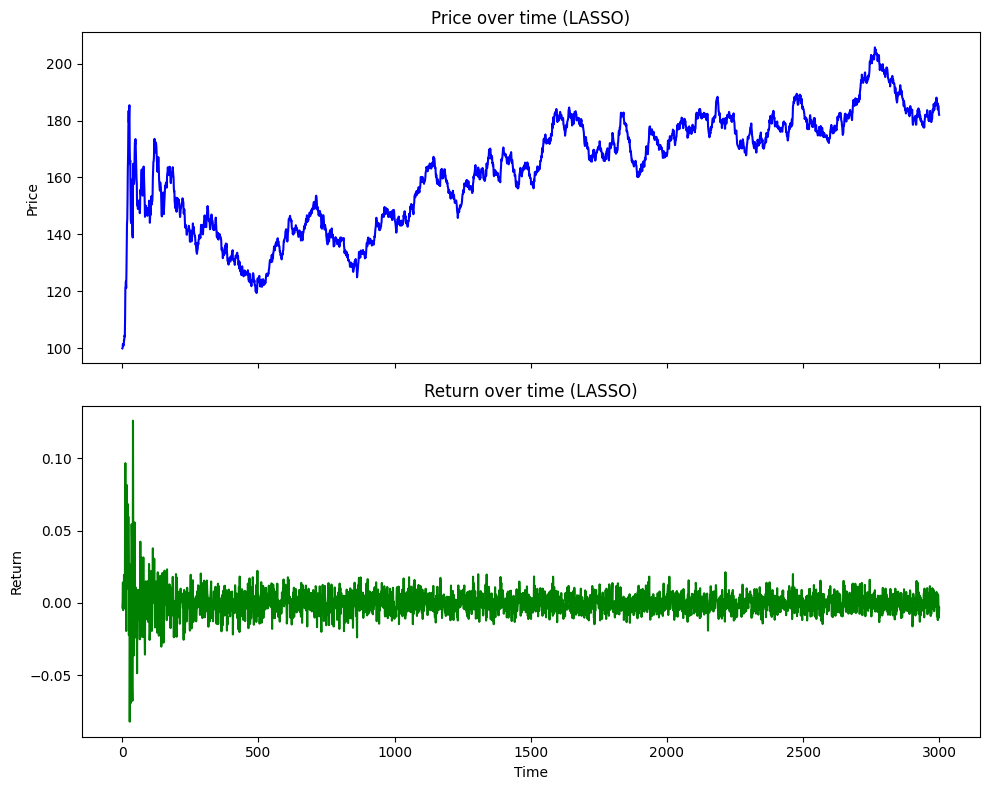

In [428]:
# Visualize price and returns
prices_lasso = np.vstack(Lasso_agent.history_price)
returns_lasso = Lasso_agent.r_t.flatten()   

#PLot of returns and prices
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
axs[0].plot(prices_lasso, color='blue')
axs[0].set_title("Price over time (LASSO)")
axs[0].set_ylabel("Price")
axs[1].plot(returns_lasso, color='green')   
axs[1].set_title("Return over time (LASSO)")
axs[1].set_ylabel("Return")
axs[1].set_xlabel("Time")
plt.tight_layout()
plt.show()

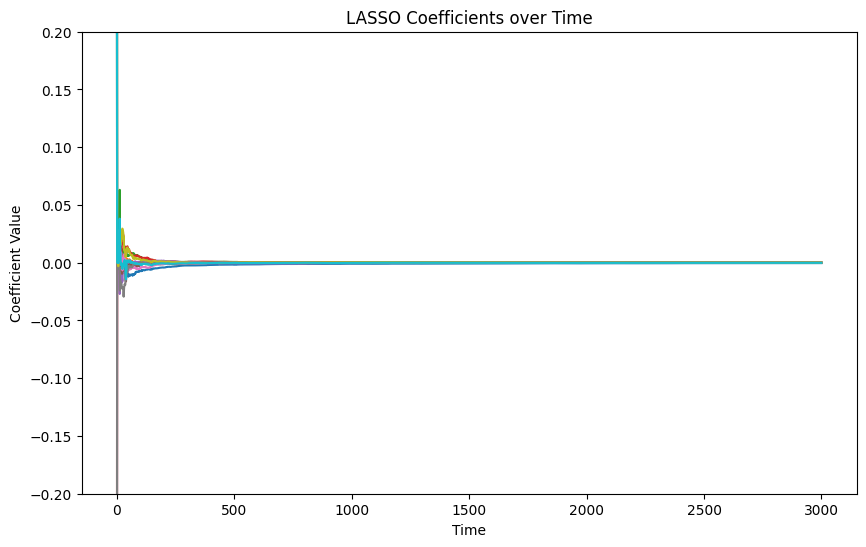

In [429]:
#visualize the beta coefficients
betas_lasso = np.vstack(Lasso_agent.history_beta)
# plot each coefficient over time
plt.figure(figsize=(10,6))
for k in range(betas_lasso.shape[1]):
    plt.plot(betas_lasso[:, k], label=f"beta_{k}")

#ylims to -1, 1
plt.ylim(-0.2, 0.2)

plt.title("LASSO Coefficients over Time")
plt.xlabel("Time")
plt.ylabel("Coefficient Value")
plt.show()

In [339]:
Theta_t = np.array([[-0.13930113, -0.70383063, -0.55155351, -0.27073313,  0.70535412],
 [ 0.52262622,  1.43257842, -0.2393064,   1.54867545, -0.74864544]])
R_t = np.array([ 0.01216669, -0.01384275])

In [350]:
np.linalg.pinv(Theta_t.T @ Theta_t) @ Theta_t.T @ R_t


array([-0.00088629, -0.00568838, -0.00582221, -0.00118855,  0.00638904])

In [ ]:
beta_ols = np.linalg.pinv(Theta_t.T @Theta_t) @ R_t

In [351]:
N = 100
K = 5
#Theta_t = np.random.normal(0, 1, (N, K))
#R_t = np.random.normal(0, 1, N)

model = Lasso(alpha=0.001, fit_intercept=False)
model.fit(Theta_t, R_t)
model.coef_

array([-0.        , -0.00573095, -0.        , -0.        ,  0.00751762])